# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv') 
train_datagen = ImageDataGenerator(rescale=1./255) 
train_gen_flow = train_datagen.flow_from_dataframe( 
        dataframe=labels, 
        directory='/datasets/faces/final_files/', 
        x_col='file_name', 
        y_col='real_age', 
        target_size=(224, 224), 
        batch_size=32, 
        class_mode='raw', 
        seed=12345)


Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
labels.shape

(7591, 2)

Имеется 7591 изображение, я считаю, что это мало и поэтому нужно будет применять аугментацию для увеличения выборки.

Посмотрим на график распределения возраста.

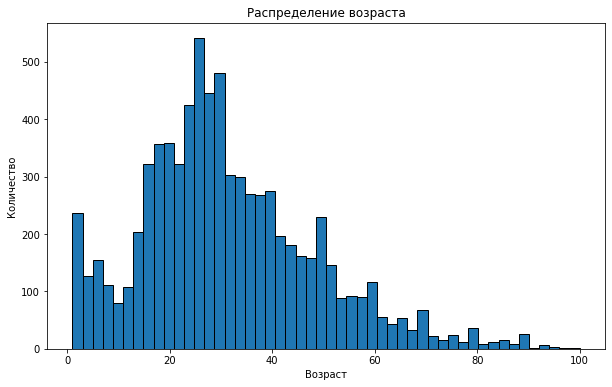

In [5]:
plt.figure(figsize=(10, 6))  
plt.hist(labels['real_age'], bins=50, edgecolor='black')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста')
plt.show()

График смещен влево. Самое часто встречаемый возраст - 25-26.

Взглянем на изображения.

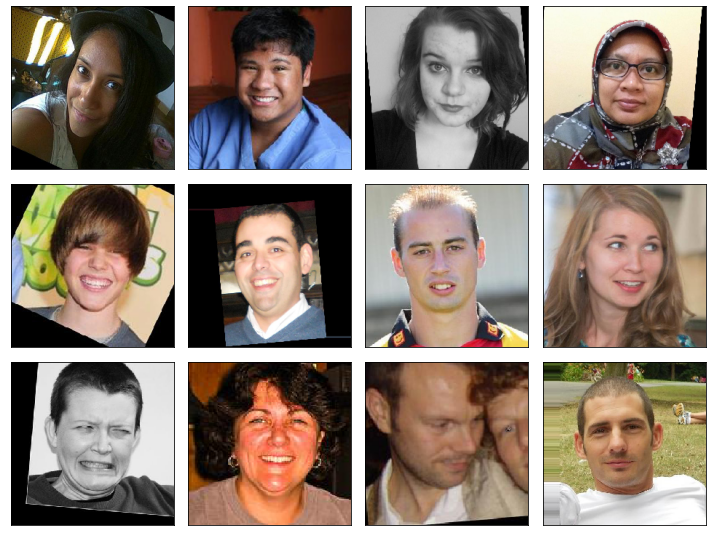

In [12]:
features, target = next(train_gen_flow)


fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете представлены черно-белыее и цветные фотографии, безэмоциональные и эмоциональные лица, а также фотографии с разным разрешением.

### Вывод

У нас имеется хороший датасет, однако стоило бы добавить лиц от 10 до 15 лет, так как это большая доля покупателей магазина.
Для решения задачи можно использовать архитектуру ResNet50, которая умеет хорошо справляться с задачами компьютерного зрения, а для улучшения метрики качества следует применить аугментацию

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow import keras
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow 

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    test_gen_flow  = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='validation')

    return test_gen_flow  

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/20
2023-08-03 23:52:42.034564: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-03 23:52:42.390782: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 54s - loss: 258.4771 - mae: 11.5210 - val_loss: 879.9456 - val_mae: 24.8027
Epoch 2/20
178/178 - 40s - loss: 80.5635 - mae: 6.7232 - val_loss: 753.2241 - val_mae: 22.3504
Epoch 3/20
178/178 - 41s - loss: 50.9086 - mae: 5.4291 - val_loss: 251.8024 - val_mae: 12.0587
Epoch 4/20
178/178 - 40s - loss: 36.2843 - mae: 4.5633 - val_loss: 116.8471 - val_mae: 8.2292
Epoch 5/20
178/178 - 41s - loss: 27.6966 - mae: 4.0083 - val_loss: 80.0380 - val_mae: 6.6764
Epoch 6/20
178/178 - 40s - loss: 21.6907 - mae: 3.5449 - val_loss: 71.8797 - val_mae: 6.3513
Epoch 7/20
178/178 - 41s - loss: 17.1003 - mae: 3.2019 - val_loss: 83.3085 - val_mae: 6.7549
Epoch 8/20
178/178 - 41s - loss: 14.3042 - mae: 2.9097 - val_loss: 67.0218 - val_mae: 6.1617
Epoch 9/20
178/178 - 40s - loss: 12.4211 - mae: 2.6715 - val_loss: 76.6092 - val_mae: 6.8115
Epoch 10/20
178/178 - 40s - loss: 11.2991 - mae: 2.5557 - val_loss: 72.0979 - val_mae: 6.3009
Epoch 11/20
178/178 - 40s - loss: 9.7302 - mae: 2.3467 - val_loss: 62.8022 - val_mae: 5.9375
Epoch 12/20
178/178 - 41s - loss: 9.0045 - mae: 2.2751 - val_loss: 74.5124 - val_mae: 6.3895
Epoch 13/20
178/178 - 40s - loss: 8.4910 - mae: 2.2075 - val_loss: 61.4846 - val_mae: 5.8954
Epoch 14/20
178/178 - 40s - loss: 7.8713 - mae: 2.0935 - val_loss: 63.9329 - val_mae: 6.0446
Epoch 15/20
178/178 - 40s - loss: 7.5638 - mae: 2.0537 - val_loss: 62.2477 - val_mae: 5.8425
Epoch 16/20
178/178 - 41s - loss: 7.5346 - mae: 2.0657 - val_loss: 65.6448 - val_mae: 6.0271
Epoch 17/20
178/178 - 39s - loss: 7.4314 - mae: 2.0693 - val_loss: 61.7925 - val_mae: 5.7960
Epoch 18/20
178/178 - 40s - loss: 7.8202 - mae: 2.1104 - val_loss: 63.2161 - val_mae: 5.9896
Epoch 19/20
178/178 - 40s - loss: 7.1067 - mae: 2.0280 - val_loss: 65.2658 - val_mae: 5.9130
Epoch 20/20
178/178 - 40s - loss: 7.0005 - mae: 2.0103 - val_loss: 63.8117 - val_mae: 6.0405
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 63.8117 - mae: 6.0405
Test MAE: 6.0405

```

## Анализ обученной модели

Модель показала хороший результат по MAE, не переобучилась, несмотря на глубину. При этом обучилась достаточно быстро благодаря предобученному слою "backbone" из ResNet50. При этом можно было использовать меньшее количество эпох, и все равно пройти поставленный порог MAE <= 8, сэкономив время. Данная модель позволит решить поставленные бизнесом задачи.